<a href="https://colab.research.google.com/github/Akhilesh-K-Yadav/Explainable-AI/blob/main/Grad-CAM/GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/parth1620/GradCAM-Dataset.git 
!pip install -U git+https://github.com/albumentations-team/albumentations 
!pip install --upgrade opencv-contrib-python 

Cloning into 'GradCAM-Dataset'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 193 (delta 0), reused 193 (delta 0), pack-reused 0
Receiving objects: 100% (193/193), 2.59 MiB | 3.83 MiB/s, done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-rw2szxre
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-rw2szxre
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
import sys 
sys.path.append('/content/GradCAM-Dataset')

In [41]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import cv2

import torch 
from torch import nn 
import torch.nn.functional as F 

from torch.utils.data import DataLoader, Dataset 
from torchvision import datasets, transforms as T

from tqdm import tqdm 
import albumentations as A 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import utils

In [42]:
#Confs:
CSV_FILE = '/content/GradCAM-Dataset/train.csv'
DATA_DIR = '/content/GradCAM-Dataset/'
DEVICE = 'cuda'
BATCH_SIZE = 16
LR = 0.001
EPOCHS = 20

In [43]:
df = pd.read_csv(CSV_FILE)
df.head()

,img_path,label
0,train_images/mushroom_51.jpg,2
1,train_images/eggplant_37.jpg,1
2,train_images/mushroom_20.jpg,2
3,train_images/eggplant_51.jpg,1
4,train_images/eggplant_26.jpg,1


In [44]:
class_list = ['cucumber', 'eggplant', 'mushroom']

In [45]:
train_df, val_df = train_test_split(df, test_size= 0.2, random_state=42)

In [46]:
train_augs = A.Compose([
    A.Rotate(),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                  std=[0.229, 0.224, 0.225])
])

val_augs = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406],
                  std=[0.229, 0.224, 0.225])
])

In [47]:
trainset = utils.ImageDataset(train_df, augs= train_augs, data_dir= DATA_DIR)
valset = utils.ImageDataset(val_df, augs= val_augs, data_dir= DATA_DIR)

In [48]:
len(trainset), len(valset)

(148, 38)

In [49]:
image, label = trainset[0]
image.shape

torch.Size([3, 227, 227])

In [50]:
trainloader = DataLoader(trainset, batch_size= BATCH_SIZE, shuffle= True)
valloader  = DataLoader(valset, batch_size= BATCH_SIZE)

In [51]:
len(trainloader), len(valloader)

(10, 3)

In [52]:
#Model
class ImageModel(nn.Module):
  def __init__(self):
    super(ImageModel, self).__init__()

    self.conv_layers = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(5,5), padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(4,4), stride= 2),
        
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(5,5), padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(4,4), stride= 2),
        
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5,5), padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(4,4), stride= 2),
        
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), padding=1),
        nn.ReLU(),
             
    )

    self.maxpool = nn.MaxPool2d(kernel_size=(4,4), stride= 2)

    self.FC = nn.Sequential(
        nn.Flatten(),
        nn.Linear(6400, 2048),
        nn.ReLU(),
        nn.Linear(2048, 3)
    )

    self.gradient = None

  def activation_hook(self, grad):
    self.gradient = grad

  def get_activation_grads(self):
    return self.gradient

  def get_activation(self, x):
    return self.conv_layers(x)

  def forward(self, imgs):
    x = self.conv_layers(imgs)
    h = x.register_hook(self.activation_hook)
    x = self.maxpool(x)
    x = self.FC(x)
    return x

In [53]:
model = ImageModel()
model.to(DEVICE)

ImageModel(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (FC): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6400, out_features=2048, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=3, bias=True)
  )
)

In [54]:
def train_func(dataloader, model, optimizer, criterion):
  model.train()
  total_loss = 0.0

  for images, labels in tqdm(dataloader):
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    logits = model(images)
    optimizer.zero_grad()
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [55]:
def eval_func(dataloader, model, criterion):
  model.eval()
  total_loss = 0.0

  for images, labels in tqdm(dataloader):
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    logits = model(images)
    loss = criterion(logits, labels)
    
    total_loss += loss.item()

  return total_loss / len(dataloader)

In [56]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

In [57]:
best_val_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_func(trainloader, model, optimizer, criterion)
  val_loss = eval_func(valloader, model, criterion)

  if val_loss < best_val_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("Model saved!")
    best_val_loss = val_loss

  print(f"Epoch={i+1}, train_loss= {train_loss}, val_loss={val_loss}")

100%|██████████| 3/3 [00:00<00:00, 25.90it/s]


Model saved!
Epoch=1, train_loss= 1.2990084409713745, val_loss=1.0931893984476726


100%|██████████| 3/3 [00:00<00:00, 25.97it/s]


Model saved!
Epoch=2, train_loss= 0.9241424441337586, val_loss=0.6550924082597097


100%|██████████| 3/3 [00:00<00:00, 26.13it/s]


Model saved!
Epoch=3, train_loss= 0.6296027958393097, val_loss=0.4517841190099716


100%|██████████| 3/3 [00:00<00:00, 26.34it/s]


Model saved!
Epoch=4, train_loss= 0.4566508576273918, val_loss=0.3027281314134598


100%|██████████| 3/3 [00:00<00:00, 26.12it/s]


Model saved!
Epoch=5, train_loss= 0.2712088778614998, val_loss=0.14635115613540015


100%|██████████| 3/3 [00:00<00:00, 26.54it/s]


Epoch=6, train_loss= 0.16672161435708405, val_loss=0.18813052121549845


100%|██████████| 3/3 [00:00<00:00, 25.83it/s]


Epoch=7, train_loss= 0.2004066914319992, val_loss=0.2659591883420944


100%|██████████| 3/3 [00:00<00:00, 26.51it/s]


Model saved!
Epoch=8, train_loss= 0.2277532283216715, val_loss=0.10126174241304398


100%|██████████| 3/3 [00:00<00:00, 27.14it/s]


Model saved!
Epoch=9, train_loss= 0.14143109917640687, val_loss=0.05132266413420439


100%|██████████| 3/3 [00:00<00:00, 25.71it/s]


Epoch=10, train_loss= 0.05793707629200071, val_loss=0.2831356341096883


100%|██████████| 3/3 [00:00<00:00, 23.94it/s]


Epoch=11, train_loss= 0.23132861242629588, val_loss=0.2723404218753179


100%|██████████| 3/3 [00:00<00:00, 26.20it/s]


Epoch=12, train_loss= 0.5476709458976984, val_loss=0.10814360529184341


100%|██████████| 3/3 [00:00<00:00, 25.94it/s]


Epoch=13, train_loss= 0.15444366820156574, val_loss=0.11187004670500755


100%|██████████| 3/3 [00:00<00:00, 26.69it/s]


Epoch=14, train_loss= 0.07777643096633255, val_loss=0.12350900005549192


100%|██████████| 3/3 [00:00<00:00, 26.86it/s]


Epoch=15, train_loss= 0.038803512277081606, val_loss=0.1155349084486564


100%|██████████| 3/3 [00:00<00:00, 26.25it/s]


Epoch=16, train_loss= 0.050308113521896305, val_loss=0.11654529518758257


100%|██████████| 3/3 [00:00<00:00, 25.97it/s]


Epoch=17, train_loss= 0.02483862217050046, val_loss=0.12901362035578737


100%|██████████| 3/3 [00:00<00:00, 27.12it/s]


Epoch=18, train_loss= 0.021708807919640093, val_loss=0.08496403136329415


100%|██████████| 3/3 [00:00<00:00, 27.02it/s]


Epoch=19, train_loss= 0.00874273462104611, val_loss=0.06404910285103445


100%|██████████| 3/3 [00:00<00:00, 27.11it/s]

Epoch=20, train_loss= 0.05640781677211635, val_loss=0.06187214681995101


In [65]:
from torch.nn.modules import activation
def get_gradcam(model, image, label, size):
  label.backward()
  grads = model.get_activation_grads()
  pooled_grads = torch.mean(grads, dim= [0,2,3])
  activations = model.get_activation(image).detach()

  for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_grads[i]
  
  heatmap = torch.mean(activations, dim= 1).squeeze().cpu()
  heatmap = nn.ReLU()(heatmap)
  heatmap /= torch.max(heatmap)
  heatmap = cv2.resize(heatmap.numpy(), (size,size))

  return heatmap

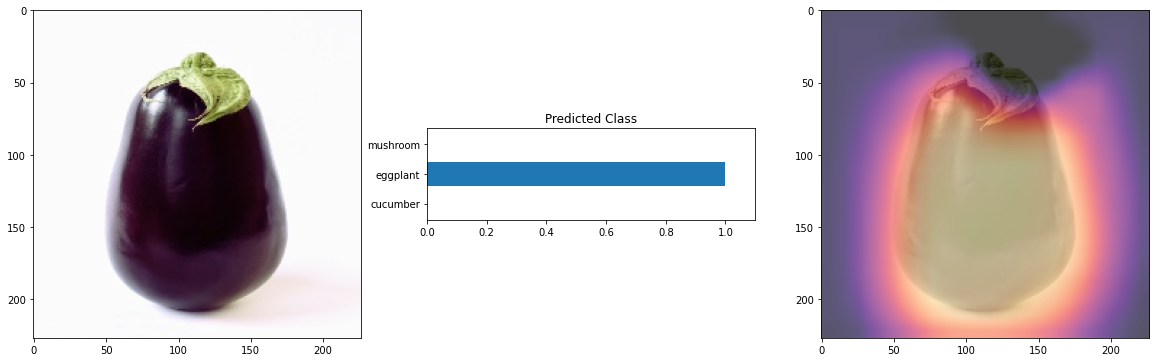

In [81]:
image, label = valset[26]
denormed_img = image.permute(1,2,0) * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
image = image.unsqueeze(0).to(DEVICE)
pred = model(image)
heatmap = get_gradcam(model, image, pred[0][1], size= 227)
utils.plot_heatmap(denormed_img, pred, heatmap)